In [23]:
import os

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

import cmcrameri.cm as cmc

In [13]:
def myround(x, base=5):
    return base * round(x/base)

In [14]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [15]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [16]:
def get_mag(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    mag = db['scardec_magnitude'].values[0]
    return mag

def get_date(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    year = db['year'].values[0]
    month = db['month'].values[0]
    day = db['day'].values[0]
    return year, month, day

In [17]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [18]:
def bootstrap(data, n=1000, proportion = 1):
    """Bootstrap resampling of data.

    Args:
        data: 1D array of data to be resampled.
        n: number of resamples to take.

    Returns:
        resampled data.
    """

    rng = np.random.default_rng()

    resampled_data = rng.choice(data, (n, int(len(data)*proportion)), replace = True)

    return resampled_data

In [19]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

results_db = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year', 'month', 'day', '10', '20', '30', '40', '50', '60', '70', '80', '90'])

colors = {'10': 'dodgerblue',
          '20': 'darkorange',
          '30': 'green',
          '40': 'red',
          '50': 'purple',
          '60': 'blue',
          '70': 'orange',
          '80': 'green',
          '90': 'red'}

for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
    #print(scardec_name)
    momentrate_opt, time_opt, db = get_stf(scardec_name, wanted_type='fctmoy')

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])

    relative_root_times = []
    for proportion in proportions_list:
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))

        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        relative_root_times.append((root_time-start_time)/duration)
    mags = get_mag(scardec_name)
    int_mags = int(mags)

    list_for_database = [scardec_name, mags, int_mags, *get_date(scardec_name), *relative_root_times]
    results_db.loc[len(results_db)] = list_for_database


In [20]:
results_10 = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year' ,'month', 'day', '0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100'])

results_10['scardec_name'] = results_db['scardec_name']
results_10['magnitude'] = results_db['magnitude']
results_10['int_magnitude'] = results_db['int_magnitude']
results_10['year'] = results_db['year']
results_10['month'] = results_db['month']
results_10['day'] = results_db['day']

results_10['0_10'] = results_db['10']
results_10['10_20'] = results_db['20'] - results_db['10']
results_10['20_30'] = results_db['30'] - results_db['20']
results_10['30_40'] = results_db['40'] - results_db['30']
results_10['40_50'] = results_db['50'] - results_db['40']
results_10['50_60'] = results_db['60'] - results_db['50']
results_10['60_70'] = results_db['70'] - results_db['60']
results_10['70_80'] = results_db['80'] - results_db['70']
results_10['80_90'] = results_db['90'] - results_db['80']
results_10['90_100'] = 1 - results_db['90']


In [21]:
results_10.sort_values(by = 'year', inplace = True, ignore_index=True)

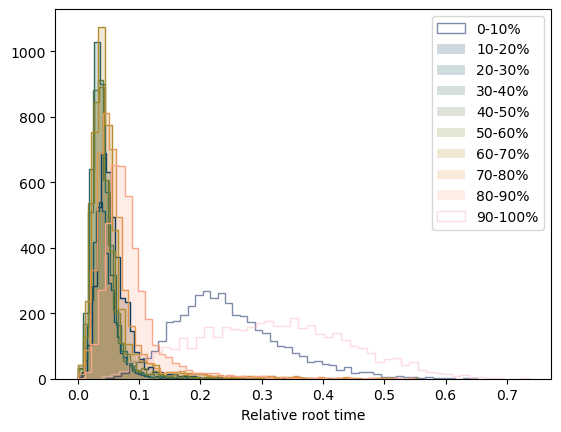

In [24]:
plt.hist(results_10['0_10'], bins = 50, color = cmc.batlow(0), label = '0-10%', alpha = 0.5, histtype = 'step')
plt.hist(results_10['10_20'], bins = 50, color = cmc.batlow(0.1), label = '10-20%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['20_30'], bins = 50, color = cmc.batlow(0.2), label = '20-30%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['30_40'], bins = 50, color = cmc.batlow(0.3), label = '30-40%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['40_50'], bins = 50, color = cmc.batlow(0.4), label = '40-50%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['50_60'], bins = 50, color = cmc.batlow(0.5), label = '50-60%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['60_70'], bins = 50, color = cmc.batlow(0.6), label = '60-70%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['70_80'], bins = 50, color = cmc.batlow(0.7), label = '70-80%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['80_90'], bins = 50, color = cmc.batlow(0.8), label = '80-90%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['10_20'], bins = 50, color = cmc.batlow(0.1), histtype = 'step')
plt.hist(results_10['20_30'], bins = 50, color = cmc.batlow(0.2), histtype = 'step')
plt.hist(results_10['30_40'], bins = 50, color = cmc.batlow(0.3), histtype = 'step')
plt.hist(results_10['40_50'], bins = 50, color = cmc.batlow(0.4), histtype = 'step')
plt.hist(results_10['50_60'], bins = 50, color = cmc.batlow(0.5), histtype = 'step')
plt.hist(results_10['60_70'], bins = 50, color = cmc.batlow(0.6), histtype = 'step')
plt.hist(results_10['70_80'], bins = 50, color = cmc.batlow(0.7), histtype = 'step')
plt.hist(results_10['80_90'], bins = 50, color = cmc.batlow(0.8), histtype = 'step')
plt.hist(results_10['90_100'], bins = 50, color = cmc.batlow(0.9), label = '90-100%', alpha = 0.5, histtype = 'step')

plt.xlabel('Relative root time')
plt.legend()

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_10_percent_windows_comparison/combined_distributions.png')

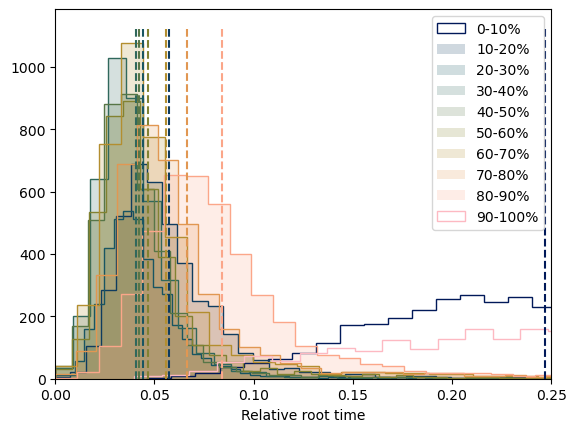

In [25]:
plt.hist(results_10['0_10'], bins = 50, color = cmc.batlow(0), label = '0-10%', alpha = 1, histtype = 'step')
plt.hist(results_10['10_20'], bins = 50, color = cmc.batlow(0.1), label = '10-20%', alpha = 0.2)
plt.hist(results_10['20_30'], bins = 50, color = cmc.batlow(0.2), label = '20-30%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['30_40'], bins = 50, color = cmc.batlow(0.3), label = '30-40%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['40_50'], bins = 50, color = cmc.batlow(0.4), label = '40-50%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['50_60'], bins = 50, color = cmc.batlow(0.5), label = '50-60%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['60_70'], bins = 50, color = cmc.batlow(0.6), label = '60-70%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['70_80'], bins = 50, color = cmc.batlow(0.7), label = '70-80%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['80_90'], bins = 50, color = cmc.batlow(0.8), label = '80-90%', alpha = 0.2)#, histtype = 'step')
plt.hist(results_10['10_20'], bins = 50, color = cmc.batlow(0.1), histtype = 'step')
plt.hist(results_10['20_30'], bins = 50, color = cmc.batlow(0.2), histtype = 'step')
plt.hist(results_10['30_40'], bins = 50, color = cmc.batlow(0.3), histtype = 'step')
plt.hist(results_10['40_50'], bins = 50, color = cmc.batlow(0.4), histtype = 'step')
plt.hist(results_10['50_60'], bins = 50, color = cmc.batlow(0.5), histtype = 'step')
plt.hist(results_10['60_70'], bins = 50, color = cmc.batlow(0.6), histtype = 'step')
plt.hist(results_10['70_80'], bins = 50, color = cmc.batlow(0.7), histtype = 'step')
plt.hist(results_10['80_90'], bins = 50, color = cmc.batlow(0.8), histtype = 'step')
plt.hist(results_10['90_100'], bins = 50, color = cmc.batlow(0.9), label = '90-100%', alpha = 1, histtype = 'step')
plt.xlabel('Relative root time')
plt.legend()

plt.xlim(0, 0.25)

y_min, y_max = plt.ylim()
plt.vlines(results_10['0_10'].mean(), y_min, y_max, color = cmc.batlow(0), linestyle = '--')
plt.vlines(results_10['10_20'].mean(), y_min, y_max, color = cmc.batlow(0.1), linestyle = '--')
plt.vlines(results_10['20_30'].mean(), y_min, y_max, color = cmc.batlow(0.2), linestyle = '--')
plt.vlines(results_10['30_40'].mean(), y_min, y_max, color = cmc.batlow(0.3), linestyle = '--')
plt.vlines(results_10['40_50'].mean(), y_min, y_max, color = cmc.batlow(0.4), linestyle = '--')
plt.vlines(results_10['50_60'].mean(), y_min, y_max, color = cmc.batlow(0.5), linestyle = '--')
plt.vlines(results_10['60_70'].mean(), y_min, y_max, color = cmc.batlow(0.6), linestyle = '--')
plt.vlines(results_10['70_80'].mean(), y_min, y_max, color = cmc.batlow(0.7), linestyle = '--')
plt.vlines(results_10['80_90'].mean(), y_min, y_max, color = cmc.batlow(0.8), linestyle = '--')
plt.vlines(results_10['90_100'].mean(), y_min, y_max, color = cmc.batlow(0.9), linestyle = '--')

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_10_percent_windows_comparison/combined_distributions_zoom_0_0.25_with_means.png')

In [26]:
results_10.describe()

,magnitude,int_magnitude,year,month,day,0_10,10_20,20_30,30_40,40_50,50_60,60_70,70_80,80_90,90_100
count,4089.000000,4089.000000,4089.000000,4089.000000,4089.000000,4089.000000,4089.000000,4089.000000,4089.000000,4089.000000,4089.000000,4089.000000,4089.000000,4089.000000,4089.000000
mean,6.327228,5.833945,2008.106383,6.642211,15.686476,0.246878,0.057410,0.044143,0.040695,0.042124,0.046630,0.055877,0.066266,0.084088,0.315888
std,0.466043,0.584002,8.423460,3.323755,8.685076,0.088429,0.029754,0.021915,0.023234,0.028344,0.035095,0.048920,0.054367,0.045646,0.123421
min,5.525000,5.000000,1992.000000,1.000000,1.000000,0.046488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039683
25%,5.991000,5.000000,2001.000000,4.000000,8.000000,0.185393,0.039326,0.030769,0.028302,0.028090,0.029630,0.033058,0.040000,0.057692,0.223140
50%,6.219000,6.000000,2008.000000,7.000000,16.000000,0.233890,0.050955,0.040179,0.036697,0.037037,0.039062,0.043478,0.052863,0.074866,0.313609
75%,6.551000,6.000000,2015.000000,9.000000,23.000000,0.296000,0.068027,0.052632,0.047945,0.048780,0.051948,0.058824,0.069930,0.096774,0.402715
max,9.026000,9.000000,2022.000000,12.000000,31.000000,0.651786,0.384058,0.245614,0.443439,0.413681,0.429825,0.553506,0.515625,0.549180,0.735426


In [27]:
means = results_10[['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']].mean()

In [28]:
upper = []
lower = []
for col_name in results_10.columns[6:]:
    bs_result = bootstrap(results_10[col_name], n=1000).mean(axis=1)
    bs_result.sort()
    lower.append(bs_result[25])
    upper.append(bs_result[975])


In [29]:
means_first_half = results_10.iloc[0:2045][['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']].mean()

In [30]:
upper_first_half = []
lower_first_half = []
for col_name in results_10.iloc[0:2045].columns[6:]:
    bs_result = bootstrap(results_10.iloc[0:2045][col_name], n=1000).mean(axis=1)
    bs_result.sort()
    lower_first_half.append(bs_result[25])
    upper_first_half.append(bs_result[975])


In [31]:
means_second_half = results_10.iloc[2045:][['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']].mean()

In [32]:
upper_second_half = []
lower_second_half = []
for col_name in results_10.iloc[2045:].columns[6:]:
    bs_result = bootstrap(results_10.iloc[2045:][col_name], n=1000).mean(axis=1)
    bs_result.sort()
    lower_second_half.append(bs_result[25])
    upper_second_half.append(bs_result[975])


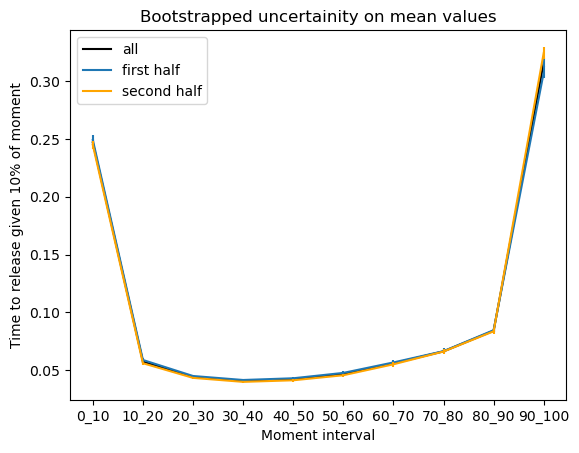

In [33]:
plt.plot(means, label = 'all', color = 'black')
plt.errorbar(means.index, means, yerr = [abs(np.array(lower)-np.array(means)), abs(np.array(upper)-np.array(means))], fmt = 'none')
plt.plot(means_first_half, label = 'first half')
plt.errorbar(means_first_half.index, means_first_half, yerr = [abs(np.array(lower)-np.array(means_first_half)), abs(np.array(upper_first_half)-np.array(means_first_half))], fmt = 'none')
plt.plot(means_second_half, color = 'orange', label = 'second half')
plt.errorbar(means_second_half.index, means_second_half, yerr = [abs(np.array(lower_second_half)-np.array(means_second_half)), abs(np.array(upper_second_half)-np.array(means_second_half))], fmt = 'none', color = 'orange')
plt.xlabel('Moment interval')
plt.ylabel('Time to release given 10% of moment')
plt.title('Bootstrapped uncertainity on mean values')
plt.legend()

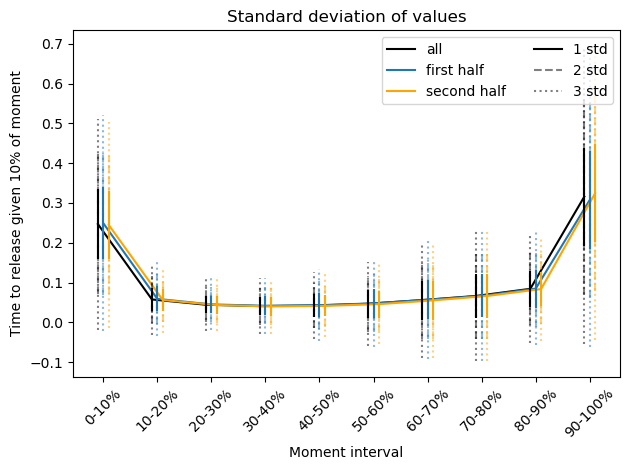

In [34]:
# Offset the x positions for the three datasets
x_offsets = np.array([-0.1, 0, 0.1])
x_positions = np.arange(len(means))

# Plot with offsets
plt.plot(x_positions + x_offsets[0], means, label='all', color='black')
plt.plot(x_positions + x_offsets[1], means_first_half, label='first half')
plt.plot(x_positions + x_offsets[2], means_second_half, color='orange', label='second half')

# Error bars with offsets
eb1 = plt.errorbar(x_positions + x_offsets[0], means, yerr=results_10[['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']].std(), fmt='none', color='black')
eb1[-1][0].set_linestyle('solid')
eb2 = plt.errorbar(x_positions + x_offsets[0], means, yerr=results_10[['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']].std()*2, fmt='none', linestyle='dashed', color='black', alpha=0.5)
eb2[-1][0].set_linestyle('--')
eb3 = plt.errorbar(x_positions + x_offsets[0], means, yerr=results_10[['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']].std()*3, fmt='none', linestyle='dotted', color='black', alpha=0.5)
eb3[-1][0].set_linestyle(':')

eb1 = plt.errorbar(x_positions + x_offsets[1], means_first_half, yerr=results_10.iloc[0:2045][['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']].std(), fmt='none', alpha=1)
eb1[-1][0].set_linestyle('solid')
eb2 = plt.errorbar(x_positions + x_offsets[1], means_first_half, yerr=results_10.iloc[0:2045][['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']].std()*2, fmt='none', linestyle='dashed', alpha=0.5)
eb2[-1][0].set_linestyle('--')
eb3 = plt.errorbar(x_positions + x_offsets[1], means_first_half, yerr=results_10.iloc[0:2045][['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']].std()*3, fmt='none', linestyle='dotted', alpha=0.5)
eb3[-1][0].set_linestyle(':')


eb1 = plt.errorbar(x_positions + x_offsets[2], means_second_half, yerr=results_10.iloc[2045:][['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']].std(), fmt='none', color='orange', alpha=1)
eb1[-1][0].set_linestyle('solid')
eb2 = plt.errorbar(x_positions + x_offsets[2], means_second_half, yerr=results_10.iloc[2045:][['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']].std()*2, fmt='none', linestyle='dashed', color='orange', alpha=0.5)
eb2[-1][0].set_linestyle('--')
eb3 = plt.errorbar(x_positions + x_offsets[2], means_second_half, yerr=results_10.iloc[2045:][['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']].std()*3, fmt='none', linestyle='dotted', color='orange', alpha=0.5)
eb3[-1][0].set_linestyle(':')

plt.xticks(x_positions, ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'], rotation=45)

plt.plot([],[], linestyle = 'solid', color = 'black', label = '1 std')
plt.plot([],[], linestyle = 'dashed', color = 'black', label = '2 std', alpha = 0.5)
plt.plot([],[], linestyle = 'dotted', color = 'black', label = '3 std', alpha = 0.5)

plt.xlabel('Moment interval')
plt.ylabel('Time to release given 10% of moment')
plt.title('Standard deviation of values')
plt.legend(ncol = 2)

plt.tight_layout()
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/comparing_halves_of_dataset/standard_deviation_of_values.png', dpi = 300)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_10_percent_windows_comparison/standard_deviation_of_values.png')
plt.show()

In [35]:
for col_name in results_10.columns[6:]:
    plt.hist(results_10[col_name], bins = 50, alpha = 0.2, density=True, label = 'all')
    plt.hist(results_10.iloc[0:2045][col_name], bins = 50, alpha = 0.2, density=True, label = 'first half')
    plt.hist(results_10.iloc[2045:][col_name], bins = 50, alpha = 0.2, density=True, label = 'second half')

    y_min, y_max = plt.ylim()

    plt.plot([],[], color = 'black', linestyle = 'dotted', label = 'median')
    plt.plot([],[], color = 'black', linestyle = 'dashed', label = 'mean')

    plt.vlines(results_10[col_name].mean(), y_min, y_max, linestyle = 'dashed', color = 'tab:blue')
    plt.vlines(results_10.iloc[0:2045][col_name].mean(), y_min, y_max, linestyle = 'dashed', color = 'tab:orange')
    plt.vlines(results_10.iloc[2045:][col_name].mean(), y_min, y_max, linestyle = 'dashed', color = 'tab:green')

    plt.vlines(results_10[col_name].median(), y_min, y_max, linestyle = 'dotted', color = 'tab:blue')
    plt.vlines(results_10.iloc[0:2045][col_name].median(), y_min, y_max, linestyle = 'dotted', color = 'tab:orange')
    plt.vlines(results_10.iloc[2045:][col_name].median(), y_min, y_max, linestyle = 'dotted', color = 'tab:green')

    plt.title(col_name)
    plt.legend()
    plt.ylabel('Density')
    plt.xlabel('Proportion of time to release given % of moment')
    plt.ylim(y_min, y_max)
    plt.xlim(0, 1)
    #plt.show()

    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/comparing_halves_of_dataset/{col_name}_percent_moment_time_intervals.png')
    plt.close()

In [36]:
col_name

'90_100'

In [37]:
bootstrapped_df = pd.DataFrame(columns = ['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100'])

lb_70 = []
ub_70 = []
lb_90 = []
ub_90 = []
lb_95 = []
ub_95 = []

for col_name in results_10.columns[6:]:
    bs_result = bootstrap(results_10[col_name], n=1000)
    bs_result = bs_result.mean(axis=1)
    bootstrapped_df[col_name] = bs_result
    bs_result.sort()
    lb_70.append(bs_result[150])
    ub_70.append(bs_result[850])
    lb_90.append(bs_result[50])
    ub_90.append(bs_result[950])
    lb_95.append(bs_result[25])
    ub_95.append(bs_result[975])

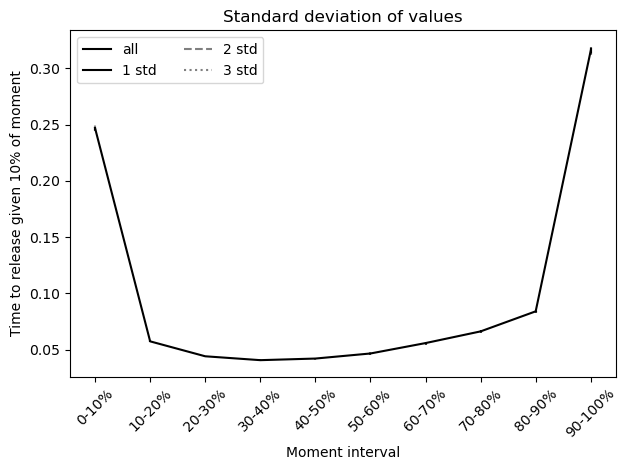

In [38]:
# Offset the x positions for the three datasets
x_positions = np.arange(len(means))

# Plot real data
plt.plot(x_positions, means, label='all', color='black')

#bootstrap data to produce error bars
bootstrapped_df = pd.DataFrame(columns = ['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100'])

lb_70 = []
ub_70 = []
lb_90 = []
ub_90 = []
lb_95 = []
ub_95 = []

for col_name in results_10.columns[6:]:
    bs_result = bootstrap(results_10[col_name], n=1000)
    bs_result = bs_result.mean(axis=1)
    bootstrapped_df[col_name] = bs_result
    bs_result.sort()
    lb_70.append(bs_result[150])
    ub_70.append(bs_result[850])
    lb_90.append(bs_result[50])
    ub_90.append(bs_result[950])
    lb_95.append(bs_result[25])
    ub_95.append(bs_result[975])

lb_70 = np.array(lb_70)
ub_70 = np.array(ub_70)
lb_90 = np.array(lb_90)
ub_90 = np.array(ub_90)
lb_95 = np.array(lb_95)
ub_95 = np.array(ub_95)

# Error bars
eb1 = plt.errorbar(x_positions, means, yerr=[abs(lb_70-means), abs(ub_70-means)], fmt='none', color='black')
eb1[-1][0].set_linestyle('solid')
eb2 = plt.errorbar(x_positions, means, yerr=[abs(lb_90-means), abs(ub_90-means)], fmt='none', linestyle='dashed', color='black', alpha=0.5)
eb2[-1][0].set_linestyle('--')
eb3 = plt.errorbar(x_positions, means, yerr=[abs(lb_95-means), abs(ub_95-means)], fmt='none', linestyle='dotted', color='black', alpha=0.5)
eb3[-1][0].set_linestyle(':')

plt.xticks(x_positions, ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'], rotation=45)

# for legend
plt.plot([],[], linestyle = 'solid', color = 'black', label = '1 std')
plt.plot([],[], linestyle = 'dashed', color = 'black', label = '2 std', alpha = 0.5)
plt.plot([],[], linestyle = 'dotted', color = 'black', label = '3 std', alpha = 0.5)

plt.xlabel('Moment interval')
plt.ylabel('Time to release given 10% of moment')
plt.title('Standard deviation of values')
plt.legend(ncol = 2)

plt.tight_layout()
#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_10_percent_windows_comparison/bs_values.png')
plt.show()
